# Threshold statistics

Original file is (threshold_stats-Copy1.ipynb)

File is designed to run interactively!!

Setup for the bias-output data.
It reads in the present and future time slice from the runs




In [1]:
import sys
import os

import intake
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
import pandas as pd 
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client()
client

2025-03-16 16:20:32,208 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-03-16 16:20:32,212 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-03-16 16:20:32,219 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0013.gadi.nci.org.au/39092/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0013.gadi.nci.org.au/39092/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44093,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0013.gadi.nci.org.au/39092/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39231,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0013.gadi.nci.org.au/39092/proxy/44721/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37697,


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def extract_model_info(filepath):
    filename = filepath.split('/')[-1]  # Get the filename from the full path
    mm = filename.split('.')[:-1]  # Remove the file extension
    model_name = '.'.join(mm)
    parts = model_name.split('_')  # Split filename by underscores
    extension = filename.split('.')[-1]  # Get the extension
#    print(parts)
    pathway = parts[3]  # Extract model (e.g., ssp370)
    GCM=parts[2]
    version=parts[5]
    RCM=parts[1]
    GWL=parts[8]
#    ensemble = parts[4]  # Extract ensemble (e.g., r1i1p1f1)
    
    return model_name ,RCM, GCM, pathway, version, GWL

## Revised Code
Current code uses GCM and RCM to determine how to structure the data into model, GWL and thresholds

Current thinking is to make a separate file for ssp126 and ssp370 for bias input and bias output (4 files) 

In [80]:
# List of periods and variables
periods = ['1995-2014', '2080-2099']
base_period = '1995-2014'

kind='ssp126'
kind='ssp370'
kind='BOM_'
kind1='CSIRO_'
kind2='WRF412R3'
kind3='WRF412R5'

# Input and output directories
data_path = '/g/data/ia39/ncra/fire/bias-input/threshold/'
data_path = '/scratch/xv83/rxm599/tmp/time/'
#output
outdir='/g/data/ia39/ncra/fire/bias-output/threshold_summary_time/'
mRuns0= sorted(glob.glob(data_path + '*'+kind+'*threshold.nc'))
mRuns1 = sorted(glob.glob(data_path + '*'+kind1+'*threshold.nc'))
mRuns2 = sorted(glob.glob(data_path + '*'+kind2+'*threshold.nc'))
mRuns3 = sorted(glob.glob(data_path + '*'+kind3+'*threshold.nc'))
mRuns=mRuns0+mRuns1+mRuns2+mRuns3
mRuns=mRuns0+mRuns1+mRuns2# +mRuns3

kind=kind3
mRuns=mRuns3
print(len(mRuns))

15


In [81]:
for mr in mRuns[67:]:
    mm=extract_model_info(mr)
    print(mm)


In [82]:
%%time
nmodel=0
for count, mm in enumerate(mRuns):
    ds=xr.open_dataset(mm)
    mname,RCM,GCM,ssp,version,Gwl=extract_model_info(mm)
    gg=RCM+'_'+GCM+'_'+version
    print(gg,version)
    d1=ds.expand_dims(GCM=[gg],ssp=[ssp])
    if count == 0:
        dall1=d1
        GCMo=GCM+version
    else:
        if GCM+version == GCMo:
            dall1 = xr.combine_by_coords([dall1,d1])
        else:
            print(f'nmodel= {nmodel}',gg)
            if nmodel == 0 :
                da3=dall1
            if nmodel >= 1 :
               da3=xr.combine_by_coords([da3,dall1]) 
            dall1=d1
            GCMo=GCM+version
            nmodel=nmodel+1

print(nmodel,'last')
da3=xr.combine_by_coords([da3,dall1]) 
#print(da3)
print(len(da3['GCM']), len(da3['ssp']))
dall=da3

NSW-Government_ACCESS-ESM1-5_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_ACCESS-ESM1-5_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_ACCESS-ESM1-5_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_EC-Earth3-Veg_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
nmodel= 0 NSW-Government_EC-Earth3-Veg_NARCliM2-0-WRF412R5
NSW-Government_EC-Earth3-Veg_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_EC-Earth3-Veg_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_MPI-ESM1-2-HR_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
nmodel= 1 NSW-Government_MPI-ESM1-2-HR_NARCliM2-0-WRF412R5
NSW-Government_MPI-ESM1-2-HR_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_MPI-ESM1-2-HR_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_NorESM2-MM_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
nmodel= 2 NSW-Government_NorESM2-MM_NARCliM2-0-WRF412R5
NSW-Government_NorESM2-MM_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Government_NorESM2-MM_NARCliM2-0-WRF412R5 NARCliM2-0-WRF412R5
NSW-Gov

In [83]:
#da3=xr.combine_by_coords([da3,dall1]) 
#da3=0
#dall1.days50[:,2,:,:].plot()
#da3.days50[:,:,:,:].max(axis=(2,3)).values
dall1

<xarray.Dataset> Size: 59MB
Dimensions:  (GCM: 1, ssp: 3, lat: 691, lon: 886)
Coordinates:
  * GCM      (GCM) object 8B 'NSW-Government_UKESM1-0-LL_NARCliM2-0-WRF412R5'
  * ssp      (ssp) object 24B 'historical' 'ssp126' 'ssp370'
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    days50   (GCM, ssp, lat, lon) float64 15MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days75   (GCM, ssp, lat, lon) float64 15MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days100  (GCM, ssp, lat, lon) float64 15MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days25   (GCM, ssp, lat, lon) float64 15MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [84]:
# compute maximum value for each model and GWL value
# nan values reflect the fact the model does not reach that GWL
dall.days50[:,:,:,:].max(axis=(2,3)).values

array([[141.7 , 171.85, 224.65],
       [140.4 , 125.85, 130.1 ],
       [142.7 , 154.6 , 185.  ],
       [140.35, 175.75, 198.5 ],
       [145.55, 171.1 , 196.  ]])

In [85]:
# compute difference from GWL1.2 
ddif100=dall.days100[:,:,:,:]-dall.days100[:,0,:,:]
ddif75=dall.days75[:,:,:,:]-dall.days75[:,0,:,:]
ddif50=dall.days50[:,:,:,:]-dall.days50[:,0,:,:]
ddif25=dall.days25[:,:,:,:]-dall.days25[:,0,:,:]
print(ddif50[:,:,:,:].max(axis=(2,3)).values)

[[ 0.   45.15 97.75]
 [ 0.    9.2  18.  ]
 [ 0.   15.6  44.15]
 [ 0.   51.5  65.6 ]
 [ 0.   44.05 68.  ]]


In [86]:
%%time
# write out the median value from all the RCMs for all GWLs
dall.days100[:,:,:,:].to_netcdf(outdir+kind+'_time_threshold_all_100.nc')
dall.days75[:,:,:,:].to_netcdf(outdir+kind+'_time_threshold_all_75.nc')
dall.days50[:,:,:,:].to_netcdf(outdir+kind+'_time_threshold_all_50.nc')
dall.days25[:,:,:,:].to_netcdf(outdir+kind+'_time_threshold_all_25.nc')

CPU times: user 528 ms, sys: 570 ms, total: 1.1 s
Wall time: 1.1 s


In [87]:
%%time
# write out the change in thresholds from GWL1.2 for each RCM
ddif100.to_netcdf(outdir+kind+'_time_change_threshold_all_100.nc')
ddif75.to_netcdf(outdir+kind+'_time_change_threshold_all_75.nc')
ddif50.to_netcdf(outdir+kind+'_time_change_threshold_all_50.nc')
ddif25.to_netcdf(outdir+kind+'_time_change_threshold_all_25.nc')

CPU times: user 478 ms, sys: 571 ms, total: 1.05 s
Wall time: 1.03 s


##  Example Plot

IndexError: index 7 is out of bounds for axis 0 with size 5

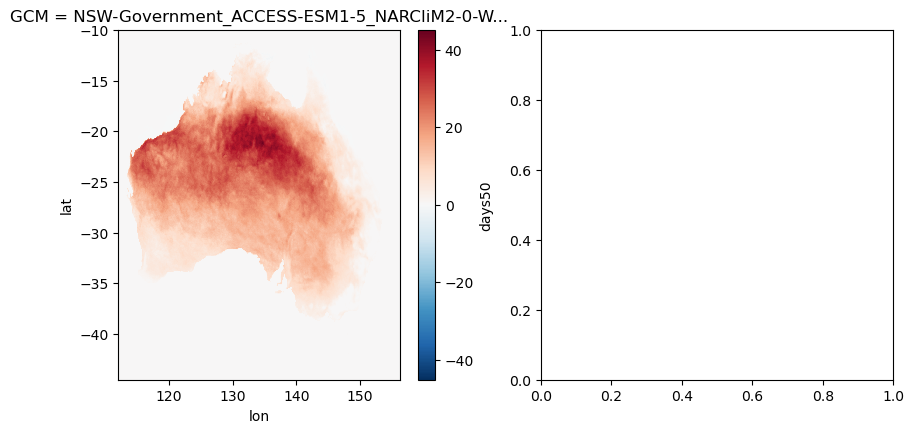

In [88]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1); ddif50[0,1,:].plot()
plt.subplot(2,2,2); ddif50[7,1,:].plot()
plt.subplot(2,2,3); ddif50[14,1,:].plot()
plt.subplot(2,2,4); ddif50[16,1,:].plot()

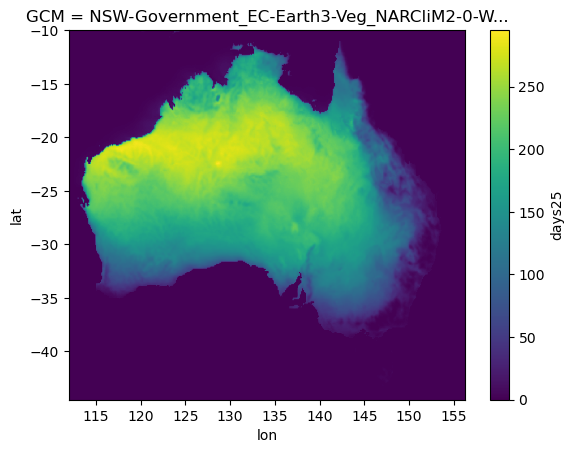

In [89]:
dall.days25[1,0,:].plot()